In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import seaborn as sns
import argparse
import subprocess
import os
import io
import gzip
import re
from collections import Iterable

/public/home/zpliu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  


In [5]:
#----------------------------------------------------------------
#! 分析1M范围内其他SNP与Top Variant的连锁度
#----------------------------------------------------------------
genotypeFile=/data/cotton/MaojunWang/WMJ_fiberFullPopulationRNAseq/fastlmm_eQTLs_V2/0DPA/0DPA_FastGENE
!plink --bfile ${genotypeFile} --r2 --ld-snp  SNP224  --ld-window-kb 1000 --ld-window 99999 --ld-window-r2 0

In [6]:
GWAS_data=pd.read_csv("~/../yjwang/zpliu/0DPA/output/Ghir_A01G000740-Ghir_D01G000710_out",header=0,index_col=0,sep="\t")
eQTL_data=pd.read_csv("../fastlmm_eGene/0DPA/output/Ghir_A01G000740-Ghir_D01G000710_At_out",header=0,index_col=0,sep="\t")
GWAS_data=GWAS_data[['Chromosome','Position','Pvalue']]
GWAS_data.columns=['chr','position','pval_nominal']
GWAS_data=GWAS_data.loc[GWAS_data['chr']==1]
eQTL_data=eQTL_data[["Chromosome","Position","Pvalue"]]
eQTL_data.columns=['chr','position','pval_nominal']
eQTL_data=eQTL_data.loc[eQTL_data['chr']==1]
#! SNP 间的连锁不平衡值
r2_s=pd.read_csv("./plink.ld",header=0,index_col=5,sep="\s+").T.loc['R2']
pvals=[GWAS_data]
# pvals=[GWAS_data,eQTL_data]
#-------------------------
#! 两个GWAS中最小的top-Variant
#-------------------------
variant_ids=['SNP226']
#* 获取top-Variant的坐标
chrom, pos = pvals[0].loc[variant_ids[0], ['chr', 'position']]
pos = int(pos)
#----------------------------------

#----------------------------------



In [3]:
GWAS_data

,chr,position,pval_nominal
SNP,,,


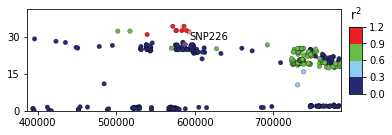

In [7]:
 # set up figure
n = len(pvals)
dl=0.75
aw=4
dr=0.75
db=0.5
ah=1.25
dt=0.25
ds=0.05
gh=0.2
th=1.5
db = 0.25
dt = 0.5

fw = dl + aw + dr  #* 图片宽度
fh = db + n*ah + (n-1)*ds + dt  #* 图片高度
gh = 0
#* 增加刻度线的高度
fh += th + ds 
fig = plt.figure(figsize=(6,4),frameon=False)
axes = [fig.add_axes([dl/fw, (fh-dt-ah)/fh, aw/fw, ah/fh])]
for i in range(1,n):
    axes.append(fig.add_axes([dl/fw, (fh-dt-ah-i*(ah+ds))/fh, aw/fw, ah/fh], sharex=axes[0]))


xlim = np.array([pos-200000, pos+200000])
axes[0].set_xlim(xlim)
axes[0].xaxis.set_major_locator(ticker.MaxNLocator(min_n_ticks=3, nbins=4))
# LocusZoom colors
lz_colors = ["#7F7F7F", "#282973", "#8CCCF0", "#69BD45","#F9A41A", "#ED1F24"]
select_args = {'s':24, 'marker':'D', 'c':"#714A9D", 'edgecolor':'k', 'lw':0.25}
highlight_args = {'s':24, 'marker':'D', 'edgecolor':'k', 'lw':0.25}
cmap = mpl.colors.ListedColormap(lz_colors)
# bounds = np.append(-1, np.arange(0,1.2,0.2)) # R2 范围在0-0.9之间
bounds = np.append(-1, np.array([0. , 0.3, 0.6, 0.9, 1.2 ])) # R2 范围在0-0.9之间
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

#* 设置图例
s = 0.66
cax = fig.add_axes([(dl+aw+0.1)/fw, (fh-dt-ah+(1-s)/2*ah)/fh, s*ah/5/fw, s*ah/fh])
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                boundaries=bounds[1:],  # start at 0
                                ticks=bounds,
                                spacing='proportional',
                                orientation='vertical')
cax.set_title('r$\mathregular{^2}$', fontsize=12)


# common set of variants 两个数据集中共有的变异
common_ix = pvals[0].index
for pval_df in pvals[1:]:
    common_ix = common_ix[common_ix.isin(pval_df.index)]


for k,(ax,variant_id,pval_df) in enumerate(zip(axes, variant_ids, pvals)):
    # select variants in window
    m = (pval_df['position']>=xlim[0]) & (pval_df['position']<=xlim[1])
    window_df = pval_df.loc[m]
    #* X轴和y轴的值
    x = window_df['position']  
    p = -np.log10(window_df['pval_nominal'])
    minp = -np.log10(pval_df.loc[variant_id, 'pval_nominal'])
    #* 绘制R2数据
    s = r2_s[window_df.index].sort_values().index
    r2 = r2_s[s].replace(np.NaN, -1)
    #* 绘制散点图
    ax.scatter(x[s], p[s], c=r2, s=20, cmap=cmap, norm=norm, edgecolor='k', lw=0.25, rasterized=False)
    #* 显示lead SNP位置 
    minpos = pval_df.loc[variant_id, 'position']
    ax.scatter(minpos, minp, **select_args)
    t = variant_id
    if (minpos-xlim[0])/(xlim[1]-xlim[0]) < 0.55:  # right
        txt = ax.annotate(t, (minpos, minp), xytext=(5,5), textcoords='offset points')
    else:
        txt = ax.annotate(t, (minpos, minp), xytext=(-5,5), ha='right', textcoords='offset points')
    txt.set_bbox(dict(facecolor='w', alpha=0.5, edgecolor='none', boxstyle="round,pad=0.1")) #* 添加背景
    ymax=None
for k,ax in enumerate(axes):
        ax.margins(y=0.2)
        if ymax is None:
            ax.set_ylim([0, ax.get_ylim()[1]])
        else:
            ax.set_ylim([0, ymax[k]])
for ax in axes:
        ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True, min_n_ticks=3, nbins=4))
        ax.margins(y=0.1)
        ax.set_facecolor('none') 

        
# fig.text(0.035, 0.65, '-log$\mathregular{_{10}}$(p-value)', va='center', rotation=90, fontsize=14)
# # plt.tight_layout() ## tight arranged
# plt.savefig("./Ghir_A05G000590-Ghir_D05G000730.pdf",dpi=600,bbox_inches="tight")
# plt.show()    

In [10]:
np.arange(0,1,0.3)

array([0. , 0.3, 0.6, 0.9])